# 2 - Análise Exploratória da Base de Dados

Concluída a fase de limpeza da base de dados, procedemos À fase de análise exploratória.

Nessa fase, buscaremos conhecer mais de perto da base de dados. Buscaremos padrões e relacionamentos interessantes entre os campos.

In [1]:
# para carregar a base de dadas limpa
import pickle

import numpy as np
import pandas as pd
from scipy import stats as spst
from tqdm import tqdm

# gráficos
import seaborn as sns
from matplotlib import rcParams, pyplot as plt

# parâmetros do matplotlib
# essencialmente, para deixar os gráficos maiores por padrão
rcParams['figure.dpi'] = 120
rcParams['figure.figsize'] = (10, 8)

## Importação e checagem de integridade

Vamos importar os dados limpos e verificar a integridade dos mesmos.

In [2]:
with open(r'../data/covid_limpo.df', 'rb') as covidfile:
    pickler = pickle.Unpickler(file = covidfile)
    covid = pickler.load()

In [3]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496285 entries, 0 to 499691
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   sex                  496285 non-null  category
 1   patient_type         496285 non-null  category
 2   pneumonia            496285 non-null  category
 3   age                  496285 non-null  int8    
 4   diabetes             496285 non-null  category
 5   copd                 496285 non-null  category
 6   asthma               496285 non-null  category
 7   inmsupr              496285 non-null  category
 8   hypertension         496285 non-null  category
 9   other_disease        496285 non-null  category
 10  cardiovascular       496285 non-null  category
 11  obesity              496285 non-null  category
 12  renal_chronic        496285 non-null  category
 13  tobacco              496285 non-null  category
 14  contact_other_covid  343718 non-null  category
 15  

In [4]:
covid.head()

,sex,patient_type,pneumonia,age,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res
id,,,,,,,,,,,,,,,,
0,0,1,0,27,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,24,0,0,0,0,0,0,0,0,0,0,NaN,1
2,1,0,0,54,0,0,0,0,0,0,0,1,0,0,NaN,1
3,0,0,1,30,0,0,0,0,0,0,0,0,0,0,NaN,1
4,1,0,0,60,1,0,0,0,1,0,1,0,0,0,NaN,1


Parece que está tudo como deveria ser.

## Análise de estatísticas descritivas do conjunto de dados

Nesta seção analisaremos as estatísticas descritivas dos dados, com o objetivo de detectar potenciais relacionamentos e/ou inconsistências.

In [5]:
covid.covid_res.value_counts(normalize = True)

0    0.558919
1    0.441081
Name: covid_res, dtype: float64

A variável dependente (`covid_res`) é razoavelmente balanceada, o que vai facilitar bastante nossa análise.

Vamos inicialmente fazer uma análise mais abrangente, com todas as variáveis disponíveis na base de dados.

In [6]:
covid.describe()

,age
count,496285.000000
mean,42.513425
std,16.622971
min,0.000000
25%,31.000000
50%,41.000000
75%,53.000000
max,120.000000


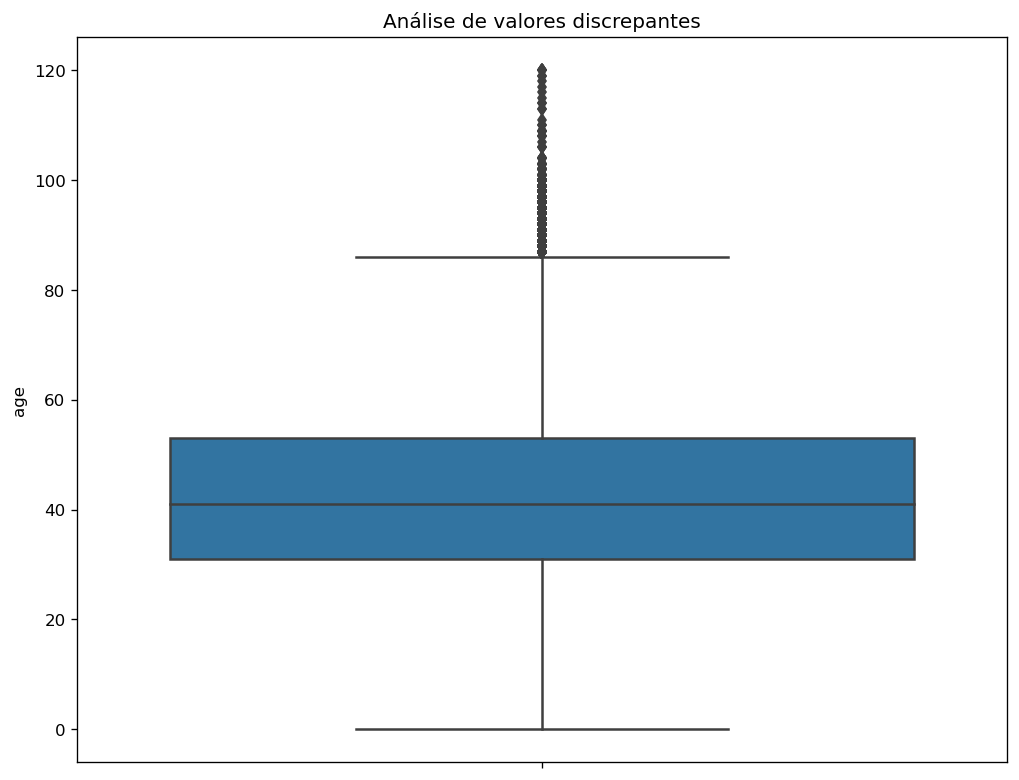

In [7]:
ax = sns.boxplot(data = covid, y = 'age')
ax.set_title('Análise de valores discrepantes')
plt.show()

Há vários valores fora do intervalo interquartil (*IQR*). Vamos separar só por idade:

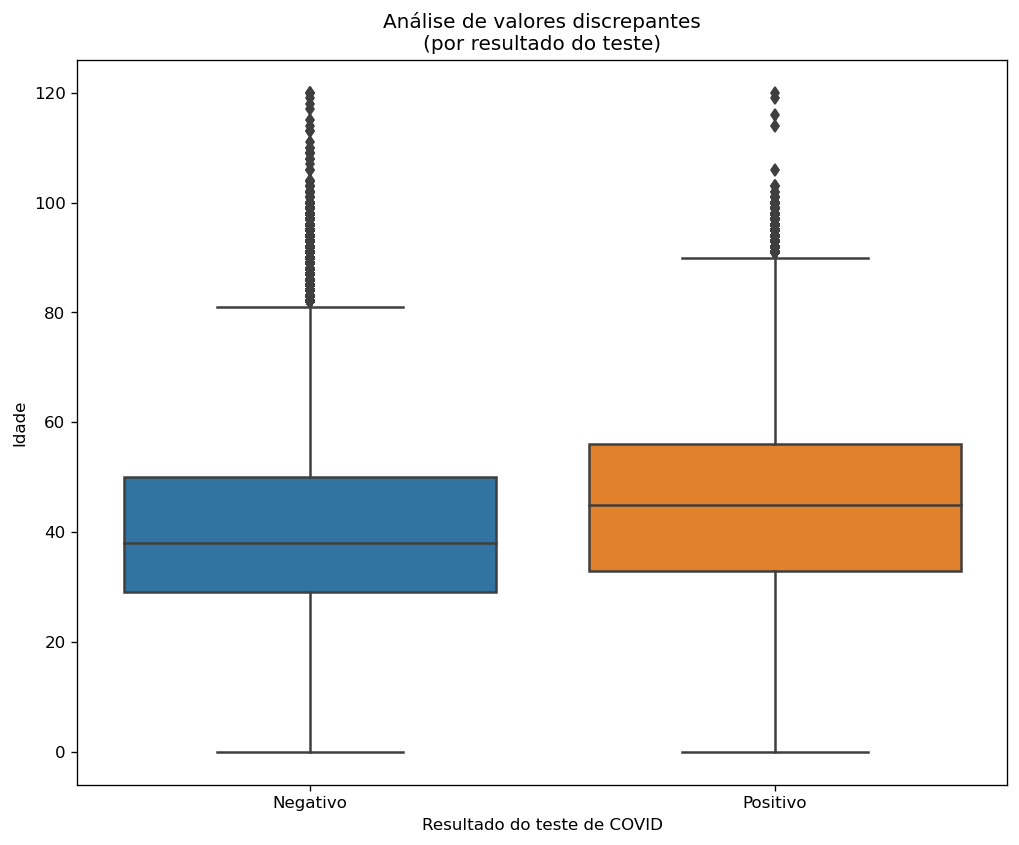

In [8]:
ax = sns.boxplot(data = covid, y = 'age', x = 'covid_res')

ax.set_title('Análise de valores discrepantes\n(por resultado do teste)')

ax.set_ylabel('Idade')
ax.set_xlabel('Resultado do teste de COVID')
ax.set_xticklabels(['Negativo', 'Positivo'])

plt.show()

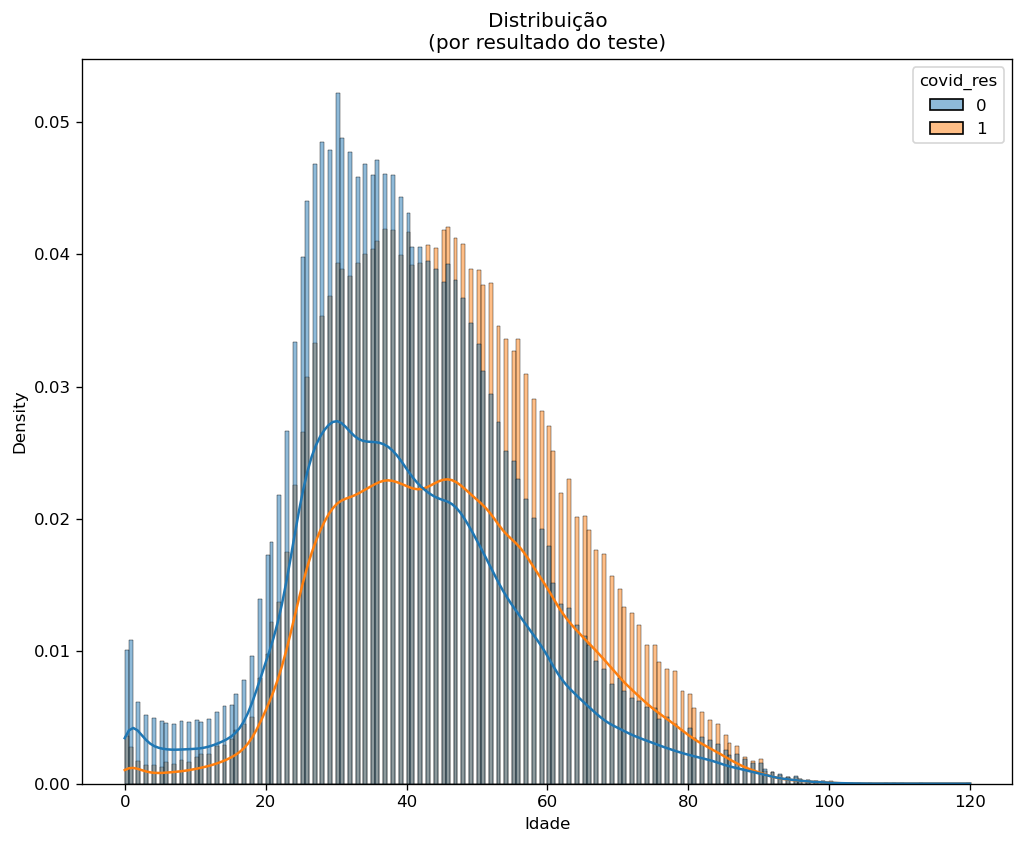

In [9]:
ax = sns.histplot(data = covid, x = 'age', hue = 'covid_res', stat = 'density', common_norm = False, kde = True, multiple = 'layer')

ax.set_title('Distribuição\n(por resultado do teste)')

ax.set_xlabel('Idade')

# handles, labels = ax.get_legend_handles_labels()
# labels = ['Negativo', 'Positivo']
# ax.legend(title = 'Resultado do teste', labels = labels, handles = handles)

plt.show()

Dos gráficos acima, conclui-se que

* a idade é uma *feature* útil para separar de forma preditiva os pacientes que testaram positivo e negativo para COVID; e
* no conjunto de dados há muitas crianças sendo testadas, a maioria com resultado negativo. Posteriormente, exploraremos a possibilidade de modelarmos o resultado do teste para crianças separadamente.

In [10]:
e_crianca = (covid.age <= 10)
e_idoso = (covid.age >= 60)
e_muito_idoso = (covid.age >= 80)
e_adulto = (~e_crianca) & (~e_idoso)

### Status de internação

É razoável supor que, se o paciente for internado, isso se deve a ele ter apresentado sintomas na chegada ao local de teste.

Vamos então separar por status de internação e resultado do teste, de forma a ter uma visão mais ampla:

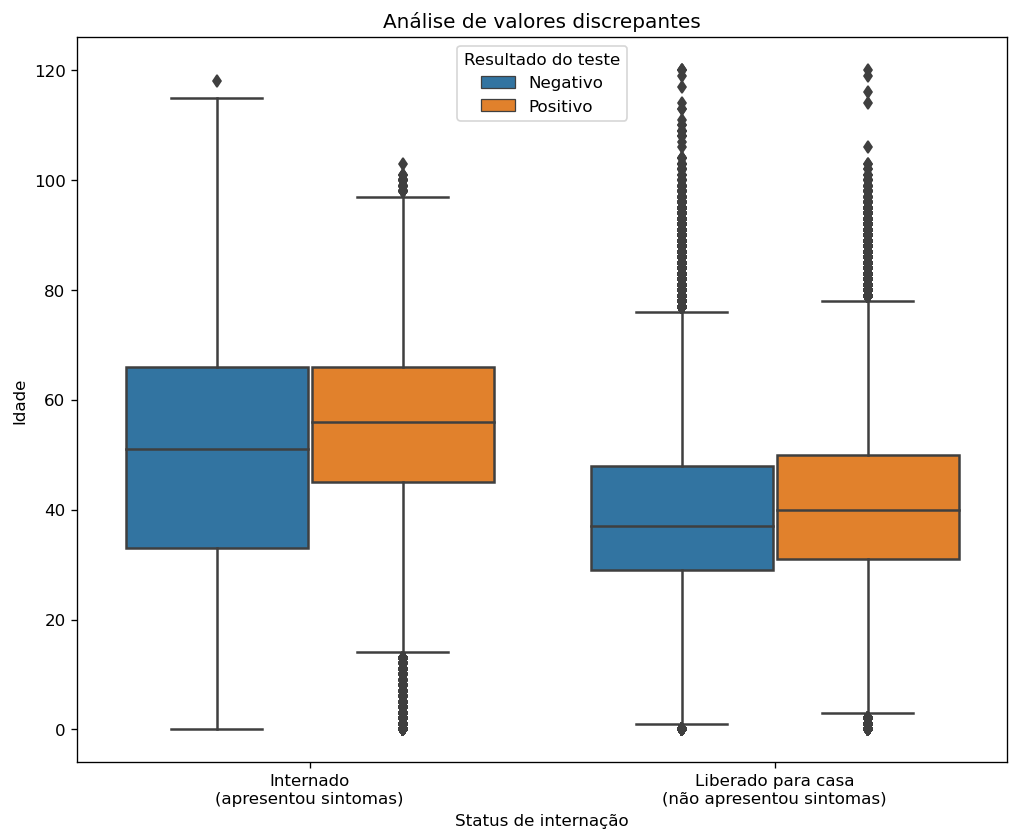

In [11]:
tem_sintomas = (covid.patient_type == 0)  # paciente internado, inferimos que apresentou sintomas. caso tenham sido
                                          # dispensados para casa, podem ter apresentado sintomas, mas eram leves
teste_positivo = (covid.covid_res == 1)

ax = sns.boxplot(data = covid, y = 'age', x = 'patient_type', hue = 'covid_res')

ax.set_title('Análise de valores discrepantes')
ax.set_ylabel('Idade')
ax.set_xlabel('Status de internação')
ax.set_xticklabels(['Internado\n(apresentou sintomas)', 'Liberado para casa\n(não apresentou sintomas)'])

handles, labels = ax.get_legend_handles_labels()
labels = ['Negativo', 'Positivo']
ax.legend(title = 'Resultado do teste', labels = labels, handles = handles, loc = 'upper center')
plt.show()

Sabemos por conhecimento de domínio que grande parte dos acometidos por COVID que apresentam algum tipo de sintoma tem idade mais avançada. Isso é confirmado pelo gráfico acima: dentre os pacientes que foram internados (ou seja, que apresentaram sintomas mais graves), a distribuição dos acometidos por COVID é mais concentrada ao redor de uma média superior à da distribuição dos não acometidos por COVID.

Os *outliers* inferiores são devido ao excesso de crianças sendo testadas, como vimos acima. Vamos ver a distribuição dos pacientes que foram liberados para casa, de forma a investigar os *outliers* superiores:

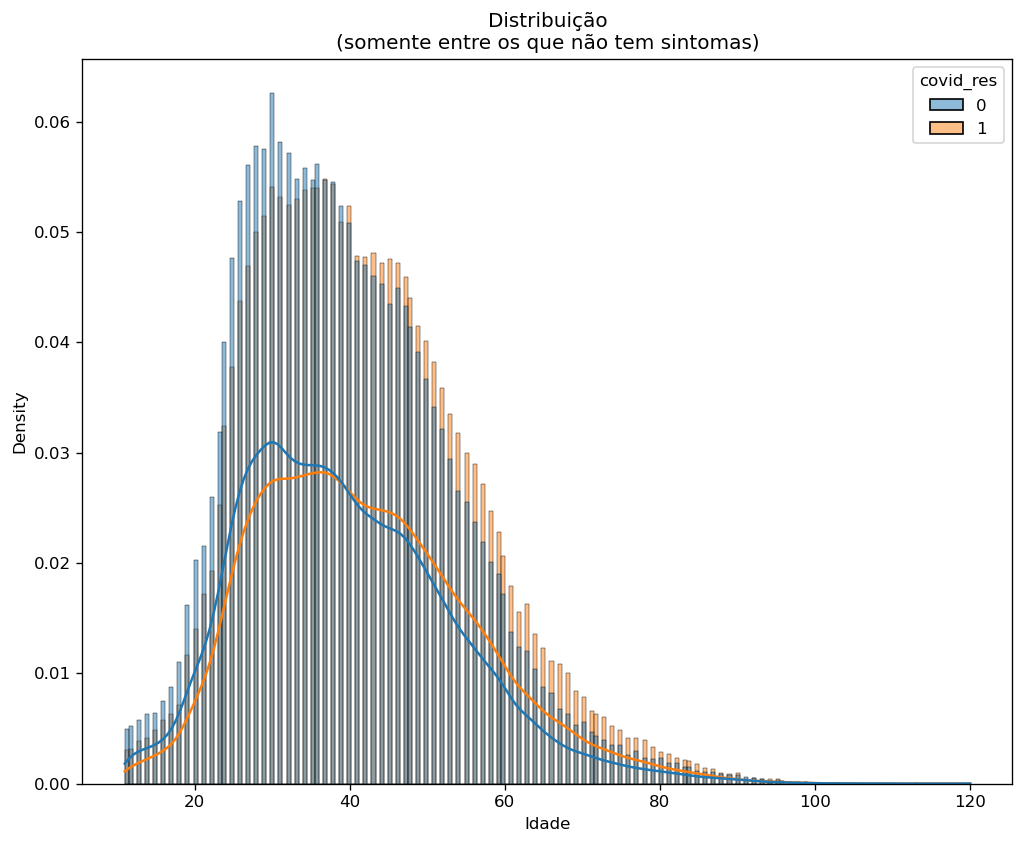

In [12]:
ax = sns.histplot(data = covid[(~tem_sintomas) & (~e_crianca)], x = 'age', hue = 'covid_res', stat = 'density', common_norm = False, kde = True, multiple = 'layer')

ax.set_title('Distribuição\n(somente entre os que não tem sintomas)')

ax.set_xlabel('Idade')

# handles, labels = ax.get_legend_handles_labels()
# labels = ['Negativo', 'Positivo']
# ax.legend(title = 'Resultado do teste', labels = labels, handles = handles)

plt.show()

Apesar de o *boxplot* indicar a presença de *outliers* com idades superiores, o histograma não revela comportamentos muito estranhos, exceto o do excesso de crianças sendo testadas.

Além disso, os gráficos nos dizem que a idade não é muito relevante para prever um resultado de teste positivo ou negativo se o paciente tiver sido liberado para casa.

### Comorbidades

Vamos agora analisar como a presença de comorbidades afeta o resultado do teste.

Inicialmente, veremos se a presença de qualquer comorbidade tem efeito sobre o resultado do teste.

In [13]:
# separar as comorbidades por tipos
comorbs = dict(
    cardio = dict(
        nome = 'Coração',
        comorbs = [ 'hypertension', 'cardiovascular' ]
    ),
    pulmao = dict(
        nome = 'Pulmão',
        comorbs = [ 'pneumonia', 'asthma', 'copd', 'tobacco' ]
    ),
    obesidade = dict(
        nome = 'Obesidade',
        comorbs = [ 'diabetes', 'obesity' ]
    ),
    imunossuprimido = dict(
        nome = 'Imunossupressão',
        comorbs = [ 'inmsupr' ]
    ),
    outros = dict(
        nome = 'Outras',
        comorbs = [ 'renal_chronic', 'other_disease' ]
    ),
)

# inicializar o dataframe das comorbidades
# para cada coluna, True se o paciente 'id' tem aquela comorbidade, False caso contrário
comorbs_df = pd.DataFrame([],
    index = covid.index,
    columns = [ tipo['nome'] for tipo in comorbs.values() ]
)

# para cada tipo de comorbidade, fazer o filtro equivalente
for tipo, tipo_dict in comorbs.items():
    tipo_comorbs = tipo_dict['comorbs']
    
    # filtro
    tipo_dict['filtro'] = (covid[tipo_comorbs] == 1).any(axis = 'columns')

    # coluna do dataframe de comorbidades
    comorbs_df[tipo_dict['nome']] = tipo_dict['filtro']

# juntar dataframe de comorbidades com as colunas 'age' e 'covid_res' do dataframe principal
comorbs_df = pd.concat([comorbs_df, covid[['age', 'covid_res']]], axis = 'columns')

In [109]:
    pvalores_idx = pd.Index(['Coração', 'Pulmão'], name = 'comorb')
    pvalores = pd.Series(
        name = 'pvalor_covid_res', 
        index = pvalores_idx, 
        dtype=float
    )
   

In [129]:
# função para construir uma tabela de contingência 
# da coluna 'col' e a coluna do resultado do teste de COVID
# e realizar um teste qui-quadrado para verificar se as colunas são relacionadas

def calc_pvalor_quiquad(df, col):
    if isinstance(col, str):
        col1 = df[col]
        col2 = df['covid_res']
    
    else:  # assume-se que, se 'col' não for string, é um iteravel (similar a lista)
        col1 = df[col[0]]
        col2 = df[col[1]]
    
    cont = pd.crosstab(col1, col2)

    p_valor = spst.chi2_contingency(cont)[1]

    return p_valor

# função para, dado um df e uma lista de comorbidades, construir uma serie relacionando a comorbidade
# ao p-valor do teste qui-quadrado da tabela de contingencia entre a comorbidade e o resultado do
# teste de COVID

def calc_relacao_comorbs(df, cols):
    
    calc_pvalor_vectorized = np.vectorize(lambda col: calc_pvalor_quiquad(df = df, col = col))

    cols_idx = pd.Index(cols, name = 'comorb')
    pvalores = pd.Series(
        calc_pvalor_vectorized(cols_idx),
        name = 'pvalor', 
        index = cols_idx
    )
    return pvalores

def correcao_alpha_multiplas(alpha, ncomps):
    # correção de bonferroni
    return alpha / ncomps

In [57]:
# 4 gráficos boxplot
# um para criancas, um para idosos, um para outras pessoas, e um combinando

def plot_box_comorbs(conf_dict, df, nome_filtro = None, eixox = 'comorb'):

    fig, axs = plt.subplots(ncols = len(conf_dict.keys()), sharex = True, sharey = True)

    # loop pelas comorbidades
    for i, (tipo, tipo_dict) in enumerate(conf_dict.items()):

        ax = axs[i]

        nome_comorb = tipo_dict['nome']

        # desenhar o boxplot
        if eixox == 'comorb':
            sns.boxplot(data = df, 
                y = 'age', x = nome_comorb, 
                hue = 'covid_res',
                ax = ax,
                palette = sns.color_palette(None),
            )
        
        else:
            sns.boxplot(data = df, 
                y = 'age', hue = nome_comorb, 
                x = 'covid_res',
                ax = ax,
                palette = sns.color_palette('Set2'),
            )
        
        # deixar o gráfico mais bonito
        comorb_titulo = f"... {nome_comorb}"
        fracao = df[nome_comorb].sum() / df[nome_comorb].shape[0]
        comorb_titulo += f'\n({fracao:.1%} do total)'
        ax.set_title(comorb_titulo)

        if i == 0:
            ax.set_ylabel('Idade')
        else:
            ax.set_ylabel('')

        if eixox == 'comorb':
            ax.set_xlabel(f"Tem comorbidade?")
            ax.set_xticklabels(['Não', 'Sim'])

        else:
            ax.set_xlabel(f"Resultado do teste")
            ax.set_xticklabels(['Negativo', 'Positivo'])
        
        ax.get_legend().remove()
    
    # titulo do grafico
    suptitle = 'Análise de valores discrepantes (comorbidades e idade)'
    
    if nome_filtro is not None:
        suptitle += f'\n(filtro: {nome_filtro})'

    suptitle += '\nProblemas de ...'

    plt.suptitle(suptitle)
    
    # acertar dimensoes do gráfico para todos os elementos aparecerem e não ficar muito espaço em branco
    plt.tight_layout()
    
    legend_kwargs = dict(
        bbox_to_anchor = (1.05, 1.19),
        frameon = False
    )
    if eixox == 'comorb':
        handles, labels = ax.get_legend_handles_labels()
        labels = ['Negativo', 'Positivo']
        plt.legend(title = 'Resultado do teste', labels = labels, handles = handles, **legend_kwargs)

    else:            
        handles, labels = ax.get_legend_handles_labels()
        labels = ['Não', 'Sim']
        plt.legend(title = 'Tem comorbidade?', labels = labels, handles = handles, **legend_kwargs)
    
    plt.show()

    return fig

figs = {}

In [215]:
# plot do heatmap com a tabela de contingencia, % da margem vertical (tem/não tem comorbidade)

def plot_heatmap_contingencia(
    df, comorbidades,
    fmt = '.1%',
    mapa_comorb = None,
    mapa_res = None,
    fig_kwds = dict(),
    teste_quiquad = False,
    filtro = None
):

    if mapa_comorb is None:
        mapa_comorb = {
            False: 'Não',
            True: 'Sim',
            0: 'Não',
            1: 'Sim'
        }

    if mapa_res is None:
        mapa_res = {
            0: 'Negativo',
            1: 'Positivo'
        }

    contingencias = {}

    df = df.copy()
    col2 = df['covid_res'].map(mapa_res)

    for comorbidade in comorbidades:

        col1 = df[comorbidade].map(mapa_comorb)

        # tabela de contingencia com comorbidades nas linhas(tem;não tem) e resultado do teste 0/1 em duas colunas
        
        contingencia = pd.crosstab(col1, col2)  
        contingencias[comorbidade] = contingencia


    # figura
    nplots = len(comorbidades) 
    fig, axs = plt.subplots(ncols = nplots, **fig_kwds, sharex = True)

    for i, (comorbidade, contingencia) in enumerate(contingencias.items()):
        
        if nplots > 1:
            ax = axs[i]
        else:
            ax = axs
        
        # normalizar pelas linhas: o % plotado é a célula dividido pelo total de pessoas que tem/não tem a comorbidade
        contingencia_pct = contingencia.apply(lambda col: col / contingencia.sum(axis = 1))
        
        # plotar heatmap
        sns.heatmap(
            contingencia_pct, 
            annot = True, fmt = fmt, 
            cmap = 'viridis', vmax = 1, vmin = 0,
            ax = ax
        )

        # colorbar
        cbar = ax.collections[-1].colorbar
        cbar.ax.yaxis.set_major_formatter(lambda y, pos: f'{y:{fmt}}')

        # eixo x: resultado
        ax.set_xlabel('Resultado do teste de COVID')

        # eixo y
        ylabel = ax.get_ylabel()
        newylabel = f"Tem comorbidade: '{comorbidade}'?"
        ax.set_ylabel(newylabel)

        # titulo de cada subgrafico
        axtitle = f"Comorbidade '{comorbidade}'"
        if teste_quiquad:
            pvalor = spst.chi2_contingency(contingencia)[1]
            axtitle += f"\n(p-valor teste $\chi ^2$ = {pvalor:.2%})"

        ax.set_title(axtitle)

    # titulo do gráfico
    suptitle = 'Tabelas de contingência: % do total de comorbidades, margem vertical'
    if filtro is not None:
        suptitle += f'\n(filtro: {filtro})'
    plt.suptitle(suptitle)

    plt.tight_layout()
    plt.show()

    return fig

In [224]:
contingencia = pd.crosstab(comorbs_df.loc[e_adulto, 'Pulmão'], comorbs_df.loc[e_adulto, 'covid_res'])
contingencia
# sns.heatmap(pd.crosstab(comorbs_df.loc[e_crianca, 'Coração'], comorbs_df.loc[e_crianca, 'covid_res']), annot = True)

covid_res,0,1
Pulmão,,
False,191115,126235
True,43663,46145


In [225]:
spst.chi2_contingency(contingencia)

(3860.409479806657,
 0.0,
 1,
 array([[182992.34768812, 134357.65231188],
        [ 51785.65231188,  38022.34768812]]))

In [212]:
contingencia.apply(lambda col: col / contingencia.sum(axis = 1))

covid_res,0,1
Coração,,
False,0.799181,0.200819
True,0.823204,0.176796


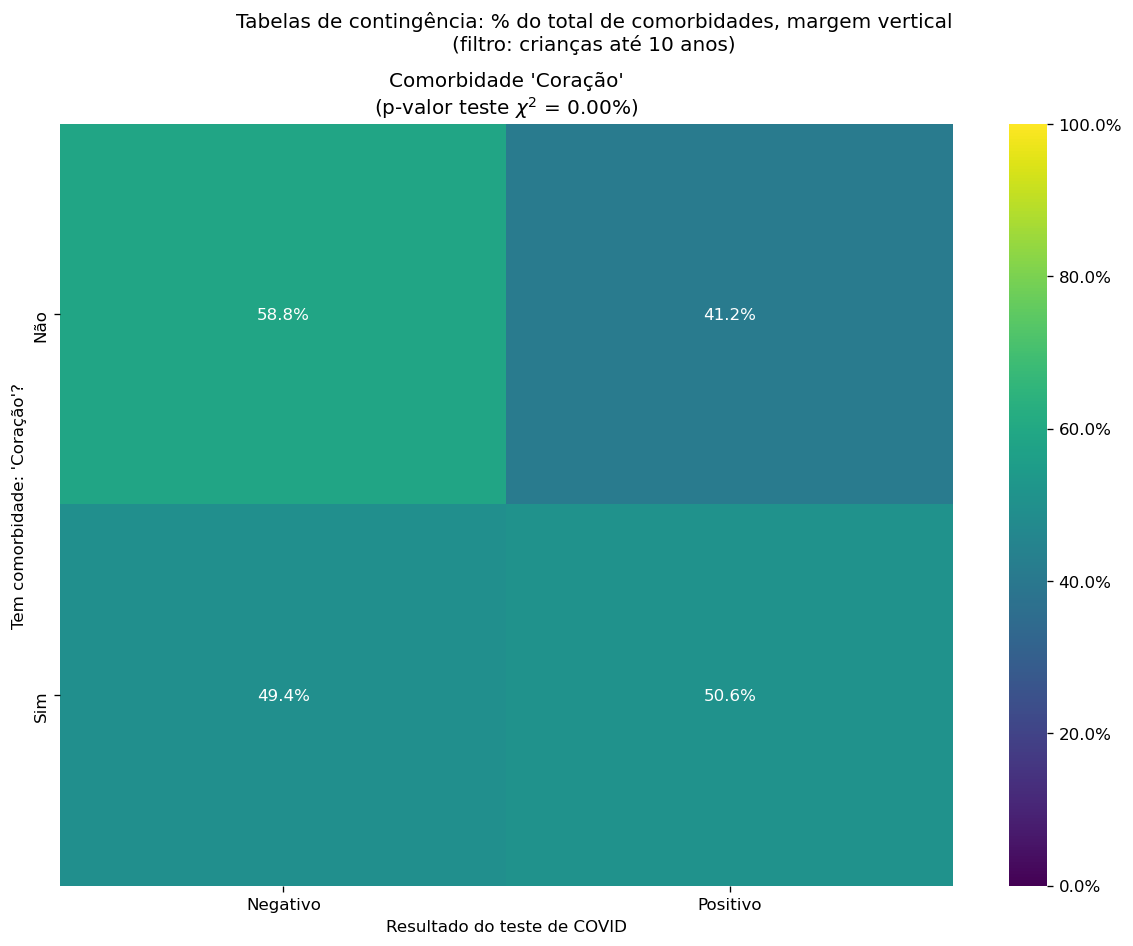

In [229]:
plot_heatmap_contingencia(df = comorbs_df[e_adulto], comorbidades = ['Coração'], filtro = 'crianças até 10 anos', teste_quiquad=True);

In [96]:
spst.chi2_contingency(contingencia)

(1.12190949485959,
 0.28950766156756985,
 1,
 array([[9766.44607063, 2443.55392937],
        [ 289.55392937,   72.44607063]]))

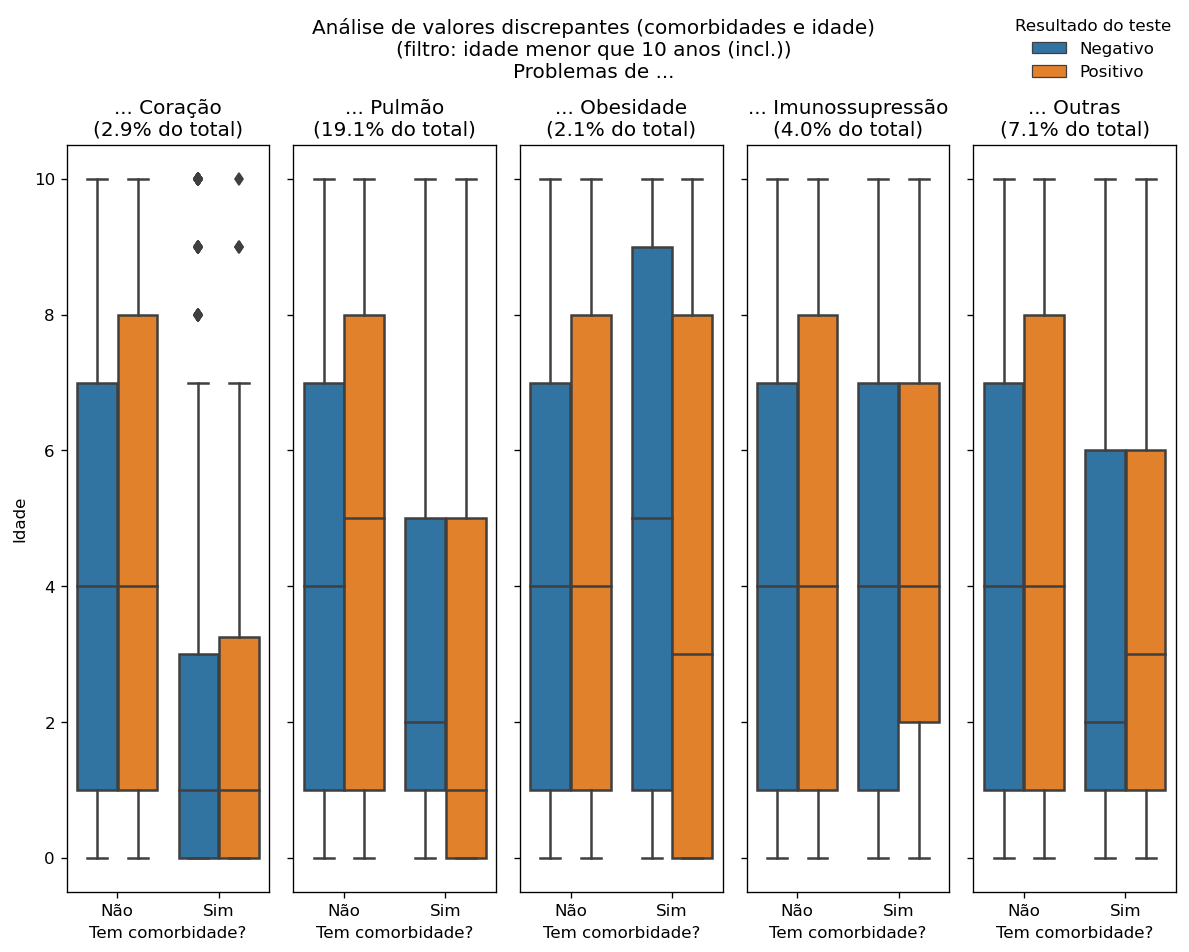

In [60]:
figs['crianca'] = plot_box_comorbs(conf_dict = comorbs, df = comorbs_df[e_crianca], nome_filtro = 'idade menor que 10 anos (incl.)', eixox = 'comorb')

Ressaltamos que, para que uma comorbidade tenha bom poder preditivo, as diferenças entre os resultados positivos e negativos devem ser o mais distante possível de zero.

Do *boxplot* acima, referindo-se somente a crianças abaixo de 10 anos, aprendemos que:

* a lógica do *quanto mais velho fica, mais tem doenças* se inverte. Crianças estão mais vulneráveis a comorbidades, principalmente cardíacas e pulmonares, quando são mais novas.
  * Uma explicação é que o sistema imunológico de crianças mais novas está menos desenvolvido que o de crianças mais velhas.

</br>

* para crianças, as comorbidades mais preditivas de um teste positivo de COVID parecem ser
  * pulmonares;
  * relacionadas à obesidade; e outras.
  
  No entanto, fora as comorbidades pulmonares, há muito poucos dados para outras doenças, de forma que o modelo não deve capturar essa diferença.

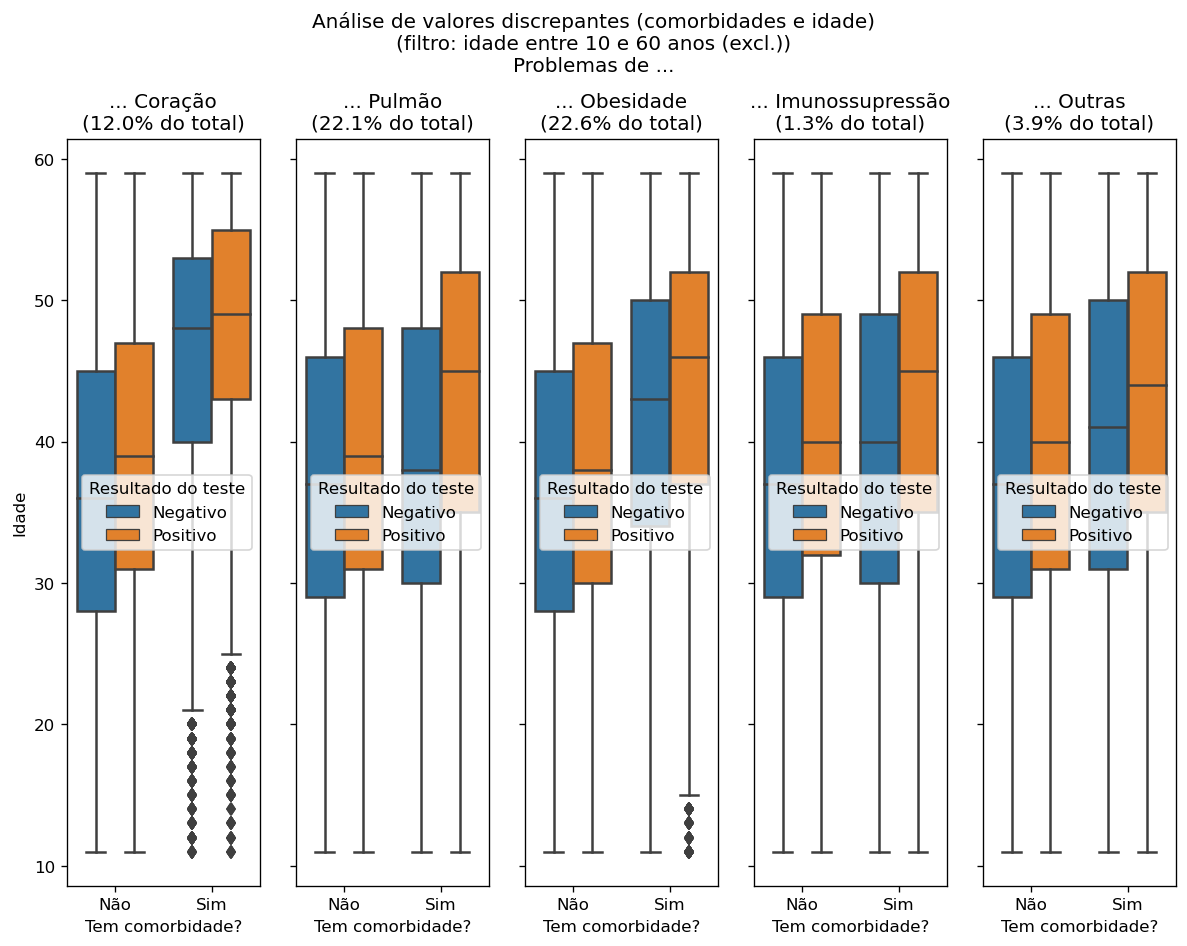

In [17]:
figs['adulto'] = plot_box_comorbs(conf_dict = comorbs, df = comorbs_df[e_adulto], nome_filtro = 'idade entre 10 e 60 anos (excl.)')

In [ ]:
figs['idoso'] = plot_box_comorbs(conf_dict = comorbs, df = comorbs_df[e_idoso], nome_filtro = 'idade maior que 60 anos (incl.)')


In [ ]:
figs['muito_idoso'] = plot_box_comorbs(conf_dict = comorbs, df = comorbs_df[e_muito_idoso], nome_filtro = 'idade maior que 80 anos (incl.)')


In [ ]:
figs['todos'] = plot_box_comorbs(conf_dict = comorbs, df = comorbs_df)


Dos *boxplots* acima, depreende-se que:

* Como era de se esperar, pacientes mais velhos claramente apresentam comorbidades mais frequentemente, independentemente do resultado do teste;
* **Com a exceção de comorbidades pulmonares e de pacientes imunossuprimidos, a presença ou não de comorbidades parece ser pouco preditiva do resultado do teste**. A diferença entre a distribuição de pacientes com testes positivos e negativos parece se manter constante entre pacientes com ou sem as comorbidades;
* Em pacientes com comorbidades pulmonares e em pacientes imunossuprimidos, a diferença entre as distribuições de pacientes com teste negativo e positivo parece ser mais dispersa que em pacientes sem essa comorbidade: